2025-05-07 10:01:35.591805: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746612095.775282      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746612095.831089      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered



--- Starting Run 1/1 ---

Dataset: MNIST (Task: classification)
11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
  Optimizer: Adam (Run 1)
    Activation: OptimA


I0000 00:00:1746612110.760208      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
I0000 00:00:1746612116.894931      57 service.cc:148] XLA service 0x78ba68016760 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746612116.895412      57 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1746612117.328965      57 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1746612119.836455      57 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


      Loss: 0.0361, Accuracy: 0.9904, Time: 61.82s, Params: 421657
      Learned params for OptimA:
        optim_a: {'alpha': 1.4601856, 'beta': 0.9055815, 'gamma': 0.9651602, 'delta': 0.9092231, 'lambda': 1.3866382}
        optim_a_1: {'alpha': 1.0377403, 'beta': 0.5682398, 'gamma': 1.0370876, 'delta': 0.70620847, 'lambda': 1.1316886}
        optim_a_2: {'alpha': 1.0795345, 'beta': 0.65063566, 'gamma': 0.99500316, 'delta': 0.44312853, 'lambda': 1.162113}
    Activation: OptimALinear
      Loss: 0.0366, Accuracy: 0.9889, Time: 46.19s, Params: 421657
      Learned params for OptimALinear:
        optim_a_linear: {'alpha': 1.0960044, 'beta': 0.5945728, 'gamma': 1.1437545, 'delta': 0.6401446, 'lambda': 1.145101}
        optim_a_linear_1: {'alpha': 1.0468371, 'beta': 0.54677725, 'gamma': 1.1901847, 'delta': 0.684242, 'lambda': 1.1963652}
        optim_a_linear_2: {'alpha': 0.98341614, 'beta': 0.61103064, 'gamma': 1.095356, 'delta': 0.5941261, 'lambda': 1.0575178}
    Activation: ReLU
    

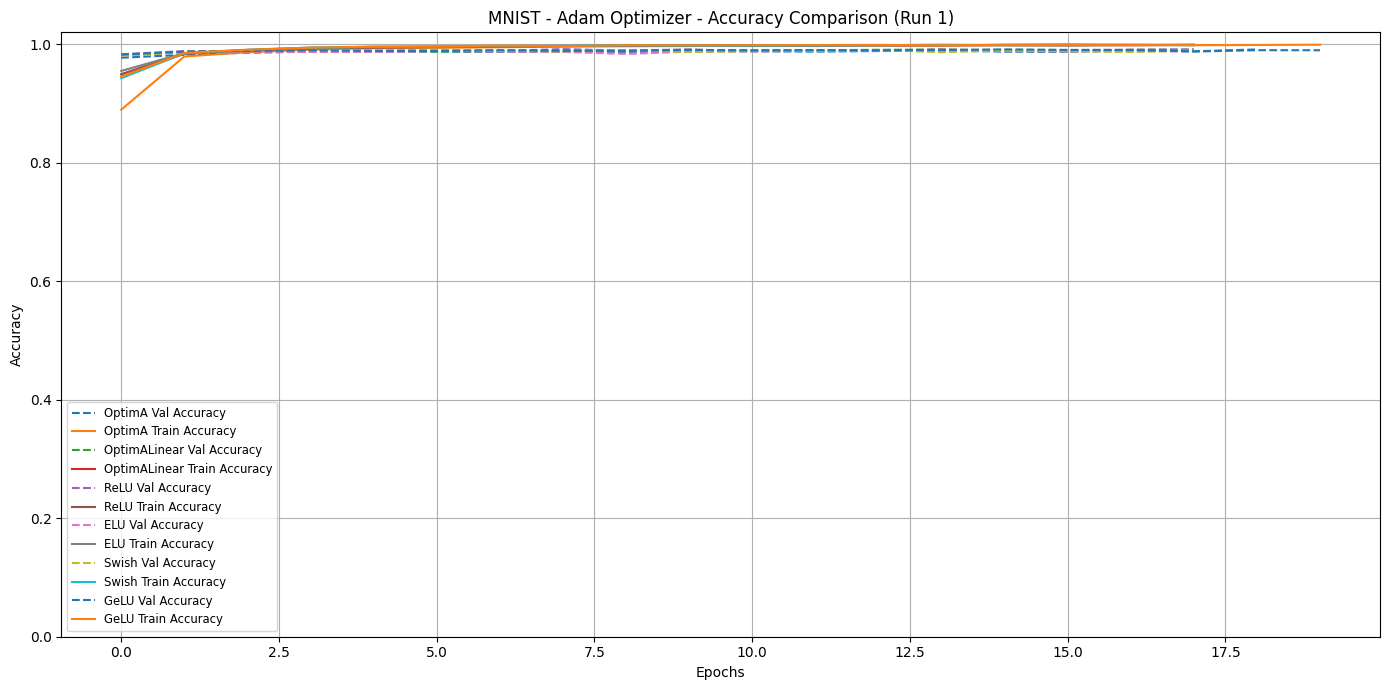

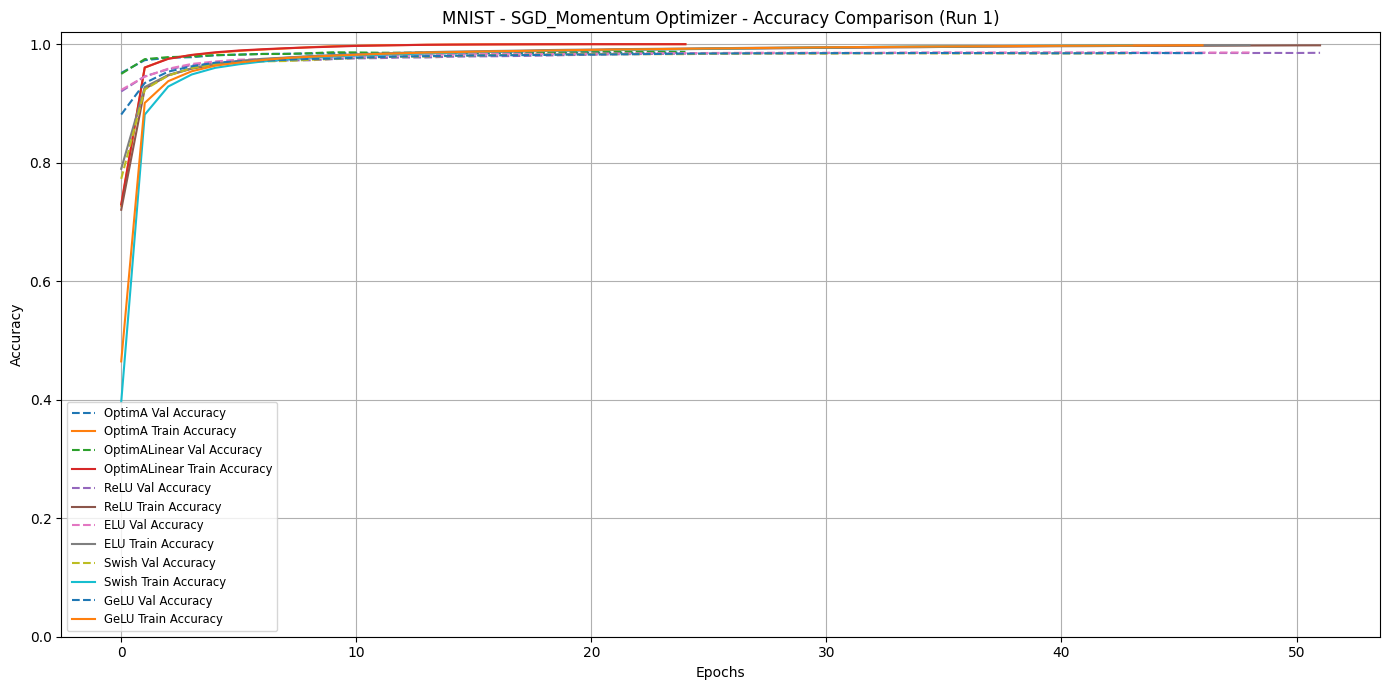

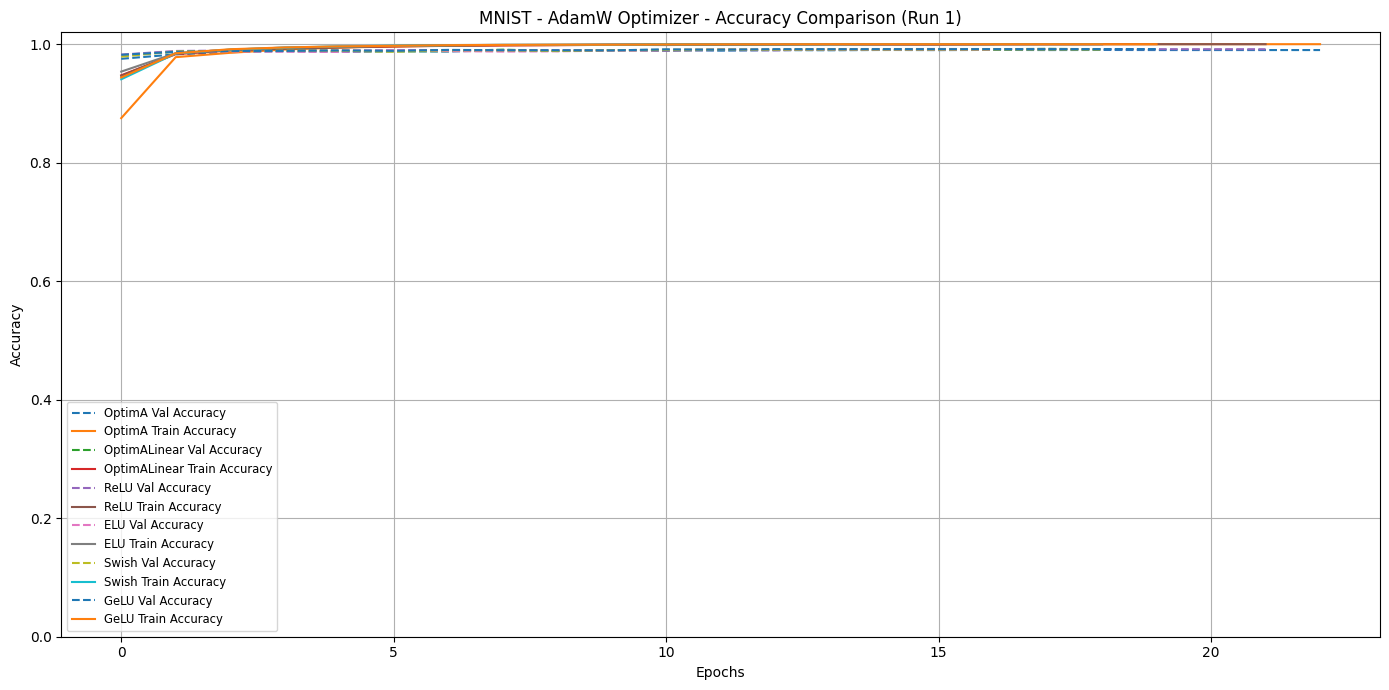

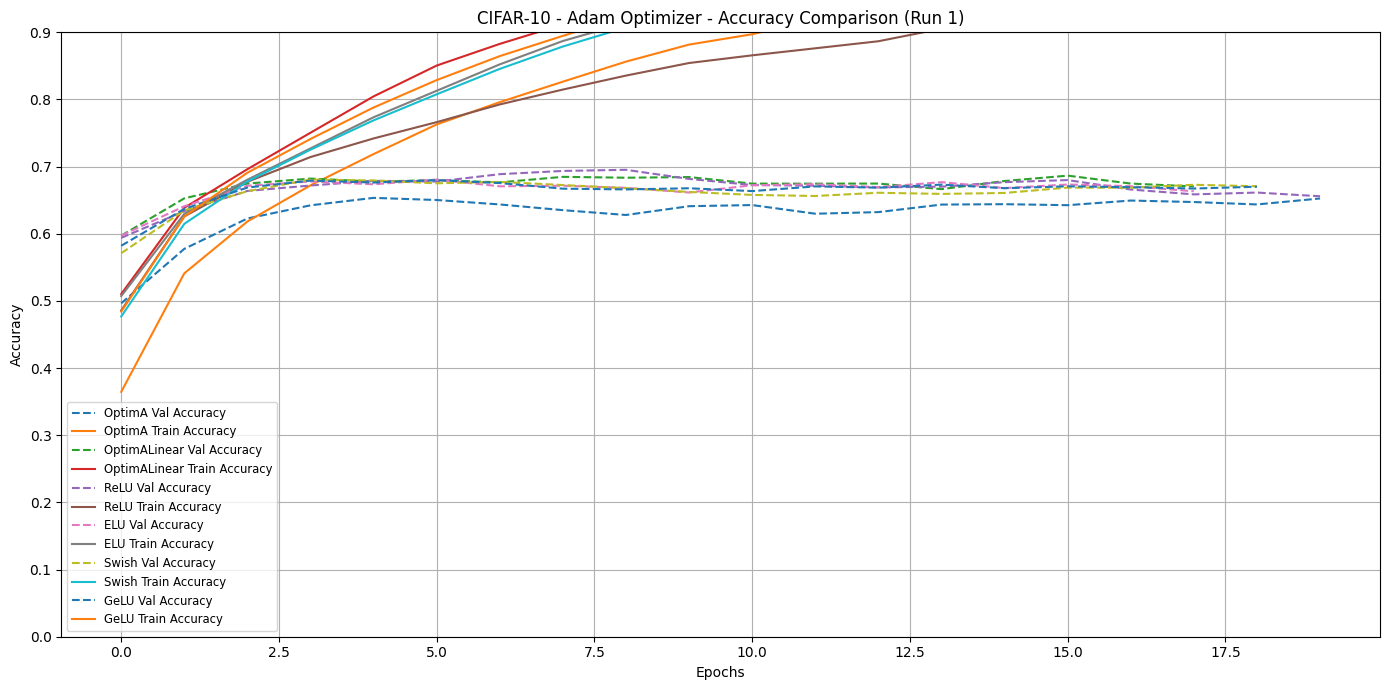

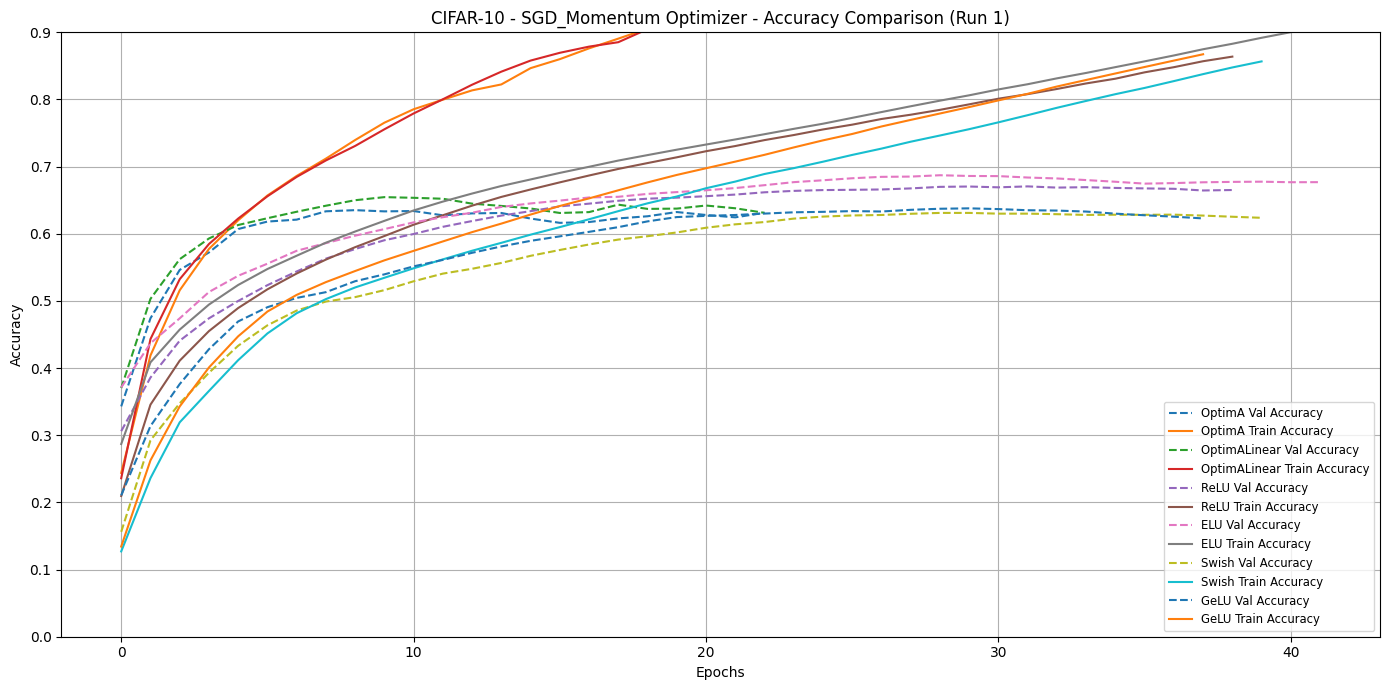

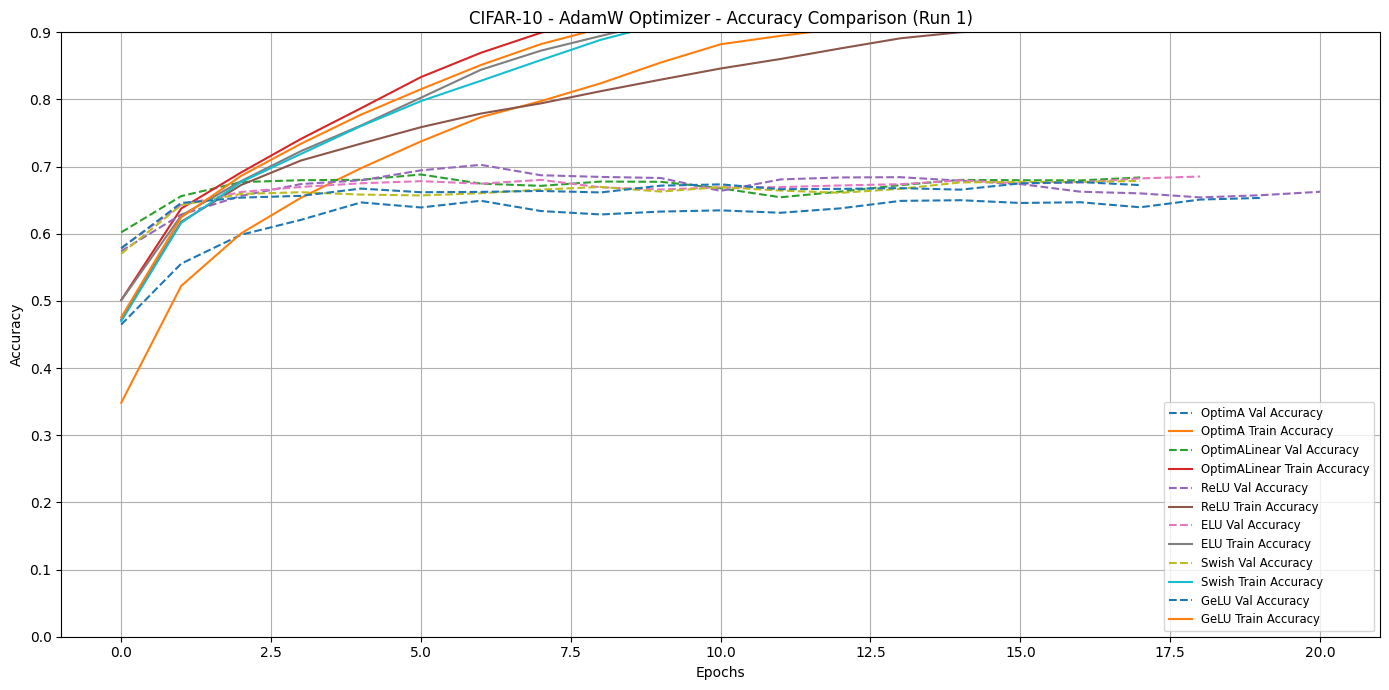

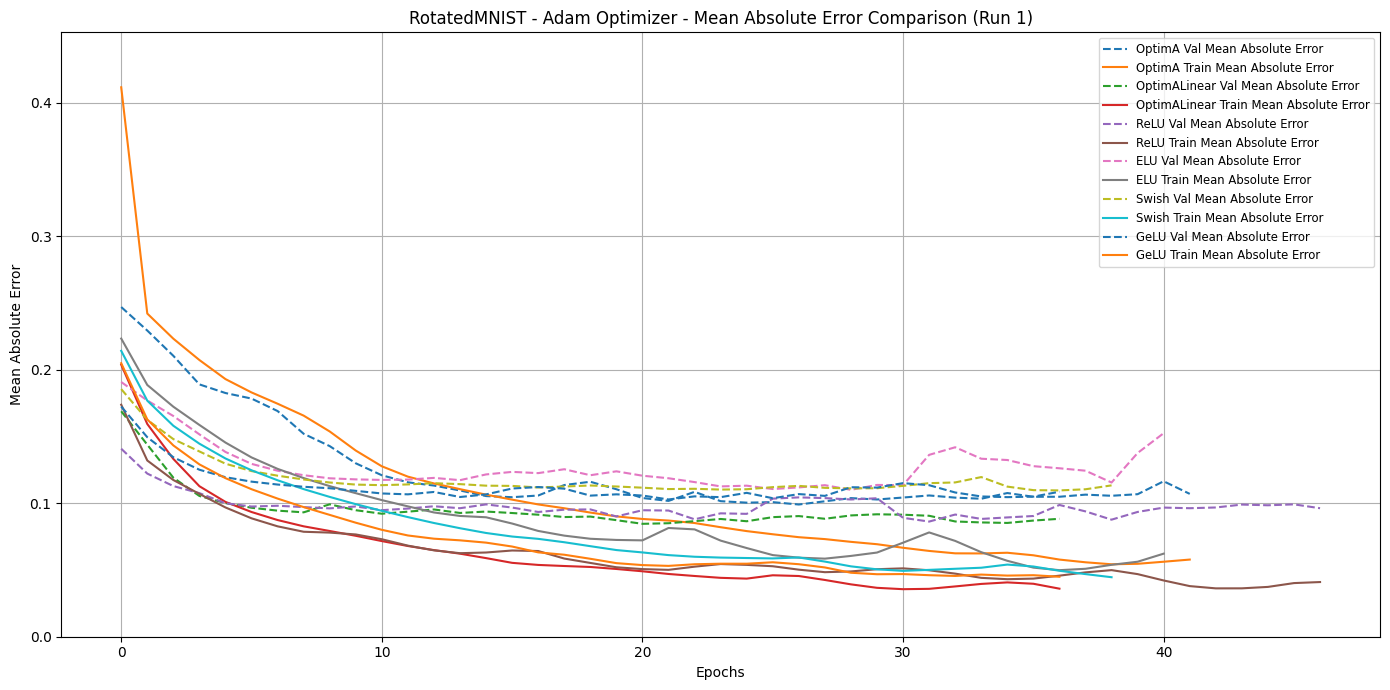

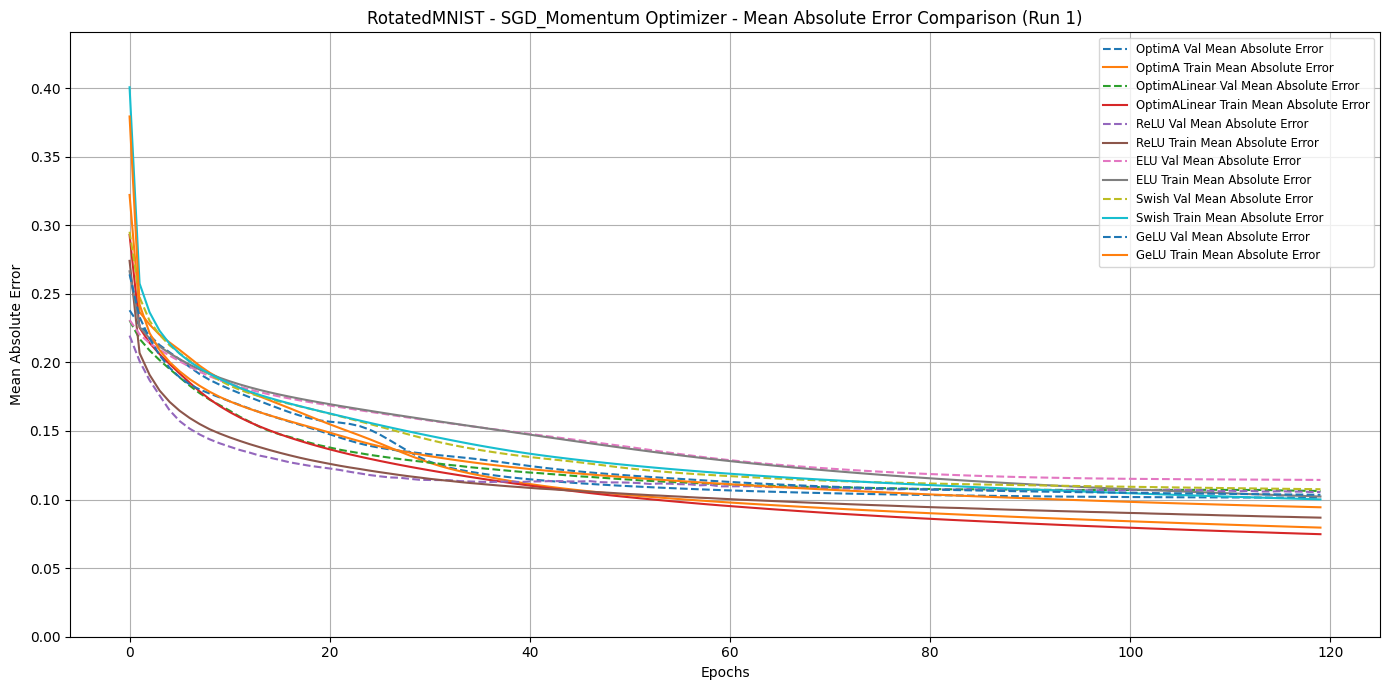

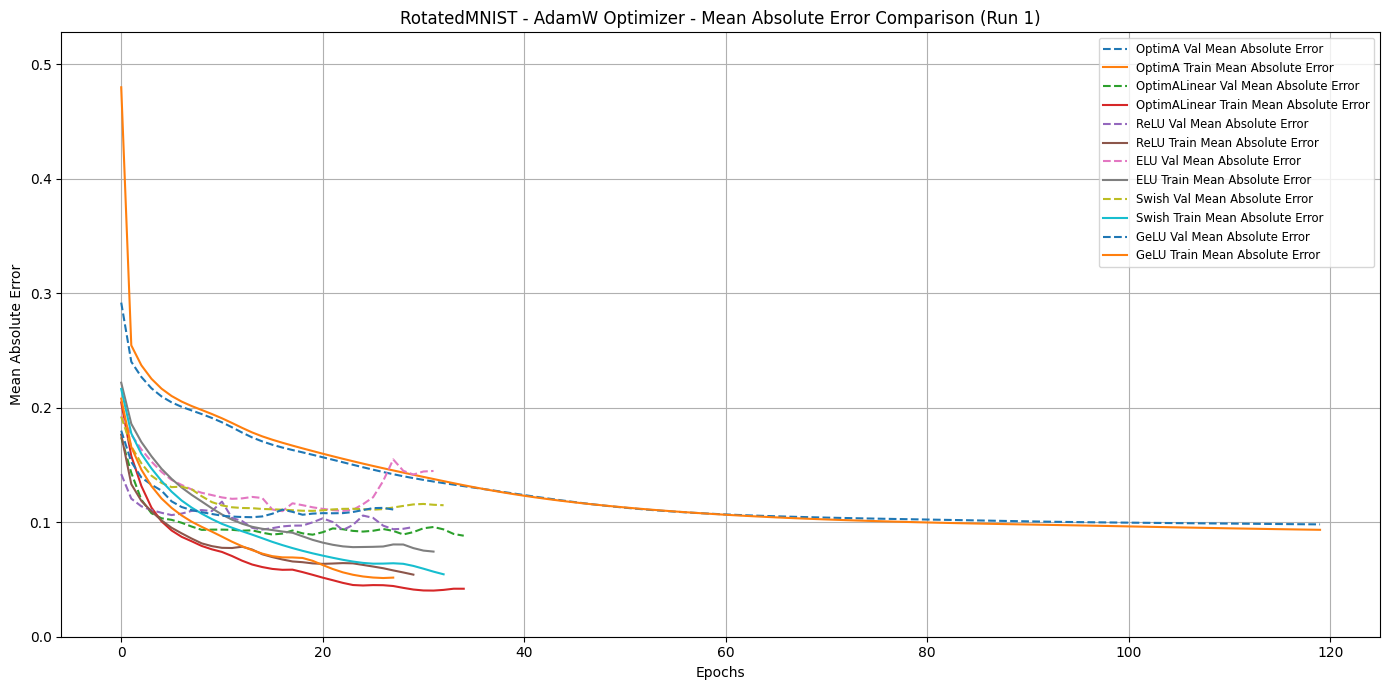

In [1]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.layers import Layer, Dense, Input, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.datasets import boston_housing, cifar10, mnist
# Import selected optimizers explicitly
from tensorflow.keras.optimizers import Adam, SGD, AdamW
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np
import pandas as pd
import random
import time
import matplotlib.pyplot as plt
from scipy.ndimage import rotate # For rotating images

# --- Configuration ---
RAND_SEED = 42
NUM_RUNS = 1 # Reduced for speed with optimizers, increase for robust results
EPOCHS = 120 # Further reduced epochs for faster multi-optimizer runs
PATIENCE = 15 # Early stopping patience
BATCH_SIZE = 64
ROTATION_ANGLE_MAX = 90 # Max angle (degrees) for Rotated MNIST
LEARNING_RATE = 1e-3 # Define a standard learning rate

def set_seed(seed=42):
    """Sets random seeds for reproducibility."""
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    # Optional: Force TensorFlow to use single thread for deterministic results
    # tf.config.threading.set_inter_op_parallelism_threads(1)
    # tf.config.threading.set_intra_op_parallelism_threads(1)

# Fix seed for initial setup, will be reset for each run
set_seed(RAND_SEED)

# --- Custom Activation Functions ---
class OptimA(Layer):  # Optimal Activation
    def __init__(self, **kwargs):
        super(OptimA, self).__init__(**kwargs)

    def build(self, input_shape):
        # Defining trainable parameters
        self.alpha = self.add_weight(name='alpha', shape=(), initializer='ones', trainable=True)
        self.beta = self.add_weight(name='beta', shape=(), initializer=tf.keras.initializers.Constant(0.5), trainable=True)
        self.gamma = self.add_weight(name='gamma', shape=(), initializer='ones', trainable=True)
        self.delta = self.add_weight(name='delta', shape=(), initializer=tf.keras.initializers.Constant(0.5), trainable=True)
        self.lambda_ = self.add_weight(name='lambda', shape=(), initializer='ones', trainable=True)

    def call(self, x):
        term1 = self.alpha * tf.math.tanh(self.beta * x)
        term2 = self.gamma * tf.math.softplus(self.delta * x) * tf.math.sigmoid(self.lambda_ * x)
        return term1 + term2

class OptimALinear(Layer):  # Optimal Activation (Linear Approximation)
    def __init__(self, epsilon=1e-5, **kwargs):
        super(OptimALinear, self).__init__(**kwargs)
        self.epsilon = epsilon

    def build(self, input_shape):
        # Defining trainable parameters
        self.alpha = self.add_weight(name='alpha', shape=(), initializer='ones', trainable=True)
        self.beta = self.add_weight(name='beta', shape=(), initializer=tf.keras.initializers.Constant(0.5), trainable=True)
        self.gamma = self.add_weight(name='gamma', shape=(), initializer='ones', trainable=True)
        self.delta = self.add_weight(name='delta', shape=(), initializer=tf.keras.initializers.Constant(0.5), trainable=True)
        self.lambda_ = self.add_weight(name='lambda', shape=(), initializer='ones', trainable=True)

    def call(self, x):
        # Linear approximation for tanh
        term1 = self.alpha * tf.clip_by_value(self.beta * x, -1, 1)
        
        # Linear approximations for softplus and sigmoid
        term2 = self.gamma * (tf.maximum(0.0, self.delta * x) + self.epsilon) * (0.5 + 0.25 * self.lambda_ * x)
        
        return term1 + term2

# --- Data Loading and Preprocessing ---

def load_and_prepare_image_classification_data(load_func, dataset_name):
    """Loads and prepares standard image classification datasets (MNIST, CIFAR-10)."""
    (x_train, y_train), (x_test, y_test) = load_func()

    x_train = x_train.astype('float32') / 255.0
    x_test = x_test.astype('float32') / 255.0

    if dataset_name == "MNIST" or dataset_name == "RotatedMNIST":
        x_train = np.expand_dims(x_train, -1)
        x_test = np.expand_dims(x_test, -1)

    num_classes = len(np.unique(np.concatenate((y_train.flatten(), y_test.flatten()))))
    y_train = to_categorical(y_train, num_classes=num_classes)
    y_test = to_categorical(y_test, num_classes=num_classes)

    return x_train, y_train, x_test, y_test, num_classes

def load_and_prepare_rotated_mnist(max_angle=ROTATION_ANGLE_MAX, seed=None):
    """Loads MNIST, rotates images, and sets the angle as the regression target."""
    if seed is not None:
        np.random.seed(seed)

    (x_train, _), (x_test, _) = mnist.load_data()

    print(f"Rotating training images (max angle: {max_angle})...")
    train_angles = np.random.uniform(-max_angle, max_angle, size=len(x_train))
    y_train_reg = train_angles / max_angle # Normalize to [-1, 1]
    x_train_rot = np.array([rotate(img, angle, reshape=False, mode='nearest', order=1) for img, angle in zip(x_train, train_angles)]) # Using bilinear interpolation (order=1)

    print(f"Rotating test images (max angle: {max_angle})...")
    test_angles = np.random.uniform(-max_angle, max_angle, size=len(x_test))
    y_test_reg = test_angles / max_angle # Normalize to [-1, 1]
    x_test_rot = np.array([rotate(img, angle, reshape=False, mode='nearest', order=1) for img, angle in zip(x_test, test_angles)]) # Using bilinear interpolation (order=1)

    x_train_rot = x_train_rot.astype('float32') / 255.0
    x_test_rot = x_test_rot.astype('float32') / 255.0
    x_train_rot = np.expand_dims(x_train_rot, -1)
    x_test_rot = np.expand_dims(x_test_rot, -1)

    print("Rotation complete.")
    return x_train_rot, y_train_reg, x_test_rot, y_test_reg

# --- Model Building ---

def build_cnn_model(input_shape, output_units, activation_func_config, task_type):
    """Builds a simple CNN model for image classification or regression."""
    # Helper to get activation layer instance or name
    def get_activation(act_config):
        if isinstance(act_config, str):
            # Standard Keras activation name
            return tf.keras.layers.Activation(act_config)
        elif isinstance(act_config, Layer):
             # It's already an instantiated custom layer (like OptimA(), OptimALinear())
             # Need to create a *new* instance for each layer in the model
             if type(act_config) == OptimA: return OptimA()
             if type(act_config) == OptimALinear: return OptimALinear()
             # Fallback: if some other layer type instance was passed
             print(f"Warning: Reusing instance of {type(act_config)} instead of creating new.")
             return act_config # This might share weights if not careful! Better to instantiate.
        elif isinstance(act_config, type) and issubclass(act_config, Layer):
             # It's a class type (like OptimA, OptimALinear)
             return act_config() # Instantiate it
        else:
             raise ValueError(f"Unsupported activation function config: {act_config}")

    # Determine activation name for model naming
    if isinstance(activation_func_config, str):
        activation_name = activation_func_config
    elif isinstance(activation_func_config, Layer):
        activation_name = activation_func_config.__class__.__name__
    elif isinstance(activation_func_config, type) and issubclass(activation_func_config, Layer):
        activation_name = activation_func_config.__name__
    else:
        activation_name = "UnknownActivation"

    model = Sequential(name=f"CNN_{activation_name}_{task_type}") # Name doesn't include optimizer here
    model.add(Input(shape=input_shape))

    model.add(Conv2D(32, kernel_size=(3, 3), padding='same'))
    model.add(get_activation(activation_func_config))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # model.add(Dropout(0.2)) # Reduced dropout

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(get_activation(activation_func_config))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # model.add(Dropout(0.2)) # Reduced dropout

    model.add(Flatten())
    model.add(Dense(128))
    model.add(get_activation(activation_func_config))
    # model.add(Dropout(0.3)) # Reduced dropout

    # --- Output Layer ---
    if task_type == "classification":
        model.add(Dense(output_units, activation='softmax'))
    elif task_type == "regression":
        # Linear activation for regression output (angles normalized to [-1, 1])
        # Tanh could also be a choice here if strictly enforcing the range is desired
        model.add(Dense(output_units, activation='linear'))
        # model.add(Dense(output_units, activation='tanh'))
    else:
        raise ValueError(f"Unsupported task type for CNN: {task_type}")

    return model

# --- Experiment Execution ---

def run_experiment(datasets_config, activations_config, optimizers_config, num_runs=NUM_RUNS, epochs=EPOCHS, batch_size=BATCH_SIZE, patience=PATIENCE):
    """Runs the benchmarking experiments across datasets, activations, and optimizers."""
    results = {}
    histories = {} # Store training histories

    for run in range(num_runs):
        print(f"\n--- Starting Run {run + 1}/{num_runs} ---")
        current_seed = RAND_SEED + run
        set_seed(current_seed) # Set seed for this specific run

        for dataset_name, dataset_config in datasets_config.items():
            print(f"\nDataset: {dataset_name} (Task: {dataset_config['task']})")
            if dataset_name not in results:
                results[dataset_name] = {}
                histories[dataset_name] = {}

            task_type = dataset_config['task']

            # Load and prepare data ONCE per dataset per run
            if dataset_config["type"] == "image" and task_type == "classification":
                 x_train, y_train, x_test, y_test, num_classes = load_and_prepare_image_classification_data(dataset_config["load_func"], dataset_name)
                 input_shape = x_train.shape[1:]
                 output_units = num_classes
                 loss_func = 'categorical_crossentropy'
                 eval_metrics = ['accuracy']
                 primary_metric = 'accuracy'
                 primary_metric_idx = 1
            elif dataset_config["type"] == "image" and task_type == "regression":
                 x_train, y_train, x_test, y_test = dataset_config["load_func"](seed=current_seed)
                 input_shape = x_train.shape[1:]
                 output_units = 1
                 loss_func = 'mse'
                 eval_metrics = ['mae']
                 primary_metric = 'mae'
                 primary_metric_idx = 1
            else:
                 raise ValueError(f"Unsupported dataset type/task combination: {dataset_config['type']}/{task_type}")

            for opt_name, optimizer_instance in optimizers_config.items():
                 print(f"  Optimizer: {opt_name} (Run {run + 1})")
                 if opt_name not in results[dataset_name]:
                    results[dataset_name][opt_name] = {}
                    histories[dataset_name][opt_name] = {}

                 for act_name, activation_config in activations_config.items():
                    print(f"    Activation: {act_name}")
                    if act_name not in results[dataset_name][opt_name]:
                        # Initialize results structure
                        results[dataset_name][opt_name][act_name] = {'loss': [], primary_metric: [], 'time': [], 'params': []}
                        histories[dataset_name][opt_name][act_name] = []

                    # Clear session and build model for each trial to reset weights and custom layer states
                    tf.keras.backend.clear_session()
                    # Crucially, set the seed again *before* building the model
                    # if we want initial weights to be the same for comparison across optimizers/activations
                    # (although TF initializers might behave slightly differently even with seed, it's best practice)
                    set_seed(current_seed) # Reset seed before model init for consistent weights

                    # --- Build Model ---
                    # Pass the activation configuration (instance or name)
                    model = build_cnn_model(input_shape, output_units, activation_config, task_type)

                    # --- Compile Model ---
                    # Use the optimizer for the current loop iteration
                    current_optimizer_instance = optimizer_instance # Get a fresh instance if defined as a class
                    if isinstance(optimizer_instance, type):
                        # If the config holds the class type, instantiate it here
                         if optimizer_instance == Adam: current_optimizer_instance = Adam(learning_rate=LEARNING_RATE)
                         elif optimizer_instance == SGD: current_optimizer_instance = SGD(learning_rate=LEARNING_RATE, momentum=0.9) # Add momentum
                         elif optimizer_instance == AdamW: current_optimizer_instance = AdamW(learning_rate=LEARNING_RATE)
                         else: current_optimizer_instance = optimizer_instance() # Generic instantiation
                    elif callable(optimizer_instance): # Handle lambda functions for instantiation
                        current_optimizer_instance = optimizer_instance()
                    else: # Assume it's already an instance (less flexible for LR adjustment per run maybe)
                        current_optimizer_instance = optimizer_instance


                    model.compile(optimizer=current_optimizer_instance,
                                  loss=loss_func,
                                  metrics=eval_metrics)

                    # --- Train Model ---
                    monitor_metric = 'val_loss'
                    early_stop = EarlyStopping(monitor=monitor_metric, patience=patience, restore_best_weights=True, verbose=0)
                    start_time = time.time()

                    history = model.fit(x_train, y_train,
                                        validation_split=0.2, # Use validation split for early stopping
                                        epochs=epochs,
                                        batch_size=batch_size,
                                        callbacks=[early_stop],
                                        verbose=0) # Keep verbose=0
                    end_time = time.time()
                    training_time = end_time - start_time

                    # --- Evaluate Model ---
                    eval_results = model.evaluate(x_test, y_test, verbose=0)
                    eval_loss = eval_results[0]
                    eval_primary_metric = eval_results[primary_metric_idx]
                    num_params = model.count_params()

                    # --- Store Results ---
                    results[dataset_name][opt_name][act_name]['loss'].append(eval_loss)
                    results[dataset_name][opt_name][act_name][primary_metric].append(eval_primary_metric)
                    results[dataset_name][opt_name][act_name]['time'].append(training_time)
                    results[dataset_name][opt_name][act_name]['params'].append(num_params)
                    histories[dataset_name][opt_name][act_name].append(history.history)

                    print(f"      Loss: {eval_loss:.4f}, {primary_metric.capitalize()}: {eval_primary_metric:.4f}, Time: {training_time:.2f}s, Params: {num_params}")

                    # Optional: Print learned parameters for OptimA/OptimALinear for the last run
                    if run == num_runs - 1 and act_name in ['OptimA', 'OptimALinear']:
                        print(f"      Learned params for {act_name}:")
                        for layer in model.layers:
                             if isinstance(layer, (OptimA, OptimALinear)):
                                 # Ensure weights are actually built (they should be after training)
                                 if hasattr(layer, 'weights') and layer.weights:
                                     param_dict = {w.name.split('/')[-1].split(':')[0]: w.numpy() for w in layer.weights}
                                     print(f"        {layer.name}: {param_dict}")
                                 else:
                                     print(f"        {layer.name}: Weights not available.")


                    del model # Clean up model object

    # --- Aggregate Results ---
    aggregated_results = {}
    for dataset_name, optimizer_data in results.items():
         aggregated_results[dataset_name] = {}
         task = datasets_config[dataset_name]['task']
         metric_key = 'accuracy' if task == 'classification' else 'mae'

         for opt_name, activation_data in optimizer_data.items():
             aggregated_results[dataset_name][opt_name] = {}
             for act_name, metrics in activation_data.items():
                 # Check if metrics list is empty (e.g., if NUM_RUNS was 0)
                 if not metrics['loss']:
                     agg_data = {
                         'Avg Loss': np.nan, 'Std Loss': np.nan,
                         f'Avg {metric_key.capitalize()}': np.nan, f'Std {metric_key.capitalize()}': np.nan,
                         'Avg Time': np.nan, 'Std Time': np.nan,
                         'Avg Params': np.nan
                     }
                 else:
                     agg_data = {
                         'Avg Loss': np.mean(metrics['loss']),
                         'Std Loss': np.std(metrics['loss']),
                         f'Avg {metric_key.capitalize()}': np.mean(metrics[metric_key]),
                         f'Std {metric_key.capitalize()}': np.std(metrics[metric_key]),
                         'Avg Time': np.mean(metrics['time']),
                         'Std Time': np.std(metrics['time']),
                         # Params should be the same across runs for the same model structure
                         'Avg Params': int(np.mean(metrics['params']))
                     }
                 aggregated_results[dataset_name][opt_name][act_name] = agg_data

    return aggregated_results, histories


# --- Main Execution ---

if __name__ == "__main__":
    # Define datasets to benchmark
    datasets_to_run = {
        "MNIST": {"load_func": mnist.load_data, "type": "image", "task": "classification"},
        "CIFAR-10": {"load_func": cifar10.load_data, "type": "image", "task": "classification"},
        "RotatedMNIST": {"load_func": load_and_prepare_rotated_mnist, "type": "image", "task": "regression"},
    }

    # Define activation functions to compare
    # Pass the class type or string name, instantiation happens in build_cnn_model
    activations_to_run = {
        'OptimA': OptimA, # Pass class type
        'OptimALinear': OptimALinear, # Pass class type
        'ReLU': 'relu',
        'ELU': 'elu',
        'Swish': 'swish',
        'GeLU': 'gelu'
    }

    # Define optimizers to compare
    # Using lambda functions to ensure fresh instances with desired config for each model compilation
    optimizers_to_run = {
        'Adam': lambda: Adam(learning_rate=LEARNING_RATE),
        'SGD_Momentum': lambda: SGD(learning_rate=LEARNING_RATE, momentum=0.9),
        'AdamW': lambda: AdamW(beta_1=0.95, beta_2=0.999, amsgrad=True)
    }

    # Run the experiments
    final_results, all_histories = run_experiment(
        datasets_to_run,
        activations_to_run,
        optimizers_to_run, # Pass the optimizers
        num_runs=NUM_RUNS,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        patience=PATIENCE
        )

    # --- Display Results ---
    all_data = []
    for dataset, opt_data in final_results.items():
        for optimizer, act_data in opt_data.items():
            for activation, metrics in act_data.items():
                 row = {'Dataset': dataset, 'Optimizer': optimizer, 'Activation': activation}
                 row.update(metrics)
                 all_data.append(row)

    results_df = pd.DataFrame(all_data)
    if not results_df.empty:
        results_df = results_df.set_index(['Dataset', 'Optimizer', 'Activation'])

        # Define columns order, including both potential primary metrics
        column_order = [
            'Avg Accuracy', 'Std Accuracy', 'Avg Mae', 'Std Mae',
            'Avg Loss', 'Std Loss', 'Avg Time', 'Std Time', 'Avg Params'
            ]
        # Reindex to ensure all columns exist, filling missing ones with NaN
        results_df = results_df.reindex(columns=column_order)
        results_df = results_df.sort_index() # Sort for better readability


    print("\n--- Aggregated Benchmark Results ---")
    pd.options.display.float_format = '{:.4f}'.format
    # print(results_df.dropna(axis=1, how='all')) # Option to hide empty columns
    print(results_df)


    # --- Optional: Plotting Training Histories ---
    print("\n--- Plotting Training Histories (Example: First Run) ---")
    run_index_to_plot = 0 # Plot history from the first run (index 0)

    if NUM_RUNS > 0: # Only plot if runs were executed
        for dataset_name, optimizer_histories in all_histories.items():
            task = datasets_to_run[dataset_name]['task']
            metric_to_plot = 'val_accuracy' if task == 'classification' else 'val_mae'
            base_metric_to_plot = 'accuracy' if task == 'classification' else 'mae' # training metric
            ylabel = 'Accuracy' if task == 'classification' else 'Mean Absolute Error'

            # Create a separate plot for each Optimizer on this dataset
            for opt_name, activation_histories in optimizer_histories.items():
                plt.figure(figsize=(14, 7))

                for act_name, history_list in activation_histories.items():
                    # Ensure history exists for the run index and contains the metric
                    if history_list and len(history_list) > run_index_to_plot:
                        run_history = history_list[run_index_to_plot]
                        if metric_to_plot in run_history:
                            plt.plot(run_history[metric_to_plot], label=f'{act_name} Val {ylabel}', linestyle='--')
                        # Also plot training metric for comparison
                        if base_metric_to_plot in run_history:
                            plt.plot(run_history[base_metric_to_plot], label=f'{act_name} Train {ylabel}', linestyle='-')


                plt.title(f'{dataset_name} - {opt_name} Optimizer - {ylabel} Comparison (Run {run_index_to_plot + 1})')
                plt.xlabel('Epochs')
                plt.ylabel(ylabel)
                plt.legend(loc='best', fontsize='small')
                plt.grid(True)

                # Adjust y-axis limits based on metric type
                if task == 'classification':
                    plt.ylim(bottom=0.0)
                    # Sensible top limits for common datasets
                    if dataset_name == "MNIST": plt.ylim(top=1.02)
                    elif dataset_name == "CIFAR-10": plt.ylim(top=0.9) # CIFAR is harder
                    else: plt.ylim(top=1.02)
                else: # Regression (MAE)
                     plt.ylim(bottom=0.0)
                     # Determine a reasonable upper limit dynamically or set fixed
                     # Example: Find max MAE across plotted histories for this optimizer/dataset
                     max_mae_val = 0.5 # Default upper limit
                     all_maes = []
                     for act_name, history_list in activation_histories.items():
                         if history_list and len(history_list) > run_index_to_plot:
                              run_history = history_list[run_index_to_plot]
                              if metric_to_plot in run_history: all_maes.extend(run_history[metric_to_plot])
                              if base_metric_to_plot in run_history: all_maes.extend(run_history[base_metric_to_plot])
                     if all_maes:
                          # Set upper limit slightly above the max observed MAE during training/validation
                          max_mae_val = max(0.1, np.max(all_maes) * 1.1) # Ensure it's at least 0.1

                     plt.ylim(top=max_mae_val)


                plt.tight_layout() # Adjust layout
                plt.show()
    else:
        print("Skipping plots as NUM_RUNS is 0.")